In [1]:
import os, sys, copy, time, math, random, numbers, itertools, tqdm, importlib, re
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rasterio
import torch
import yaml

from sklearn import metrics
from skimage import transform as trans
from pathlib import Path
from collections.abc import Sequence
from datetime import datetime, timedelta
from scipy.ndimage import rotate
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from IPython.core.debugger import set_trace

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
# The code cell is used to add the src directory to the Python path, making 
# it possible to import modules from that directory. 

module_path = os.path.abspath(os.path.join('../src'))
sys.path.insert(0, module_path)

In [76]:
from custom_dataset import CropData
from models.unet import Unet
from model_compiler import ModelCompiler
from custom_loss_functions import *
from utils import *

In [74]:
# The code cell loads a configuration file (default_config.yaml) using the YAML library and stores the 
# configuration data in the config dictionary. Then, it processes the global_stats section of the config 
# dictionary by expanding the lists for each stats based on the number of available time points. 
# As you can see we decided to generate a single set of normalization statistics and use it to 
# normalize all the time-points.

yaml_config_path = "/home/workdir/config/solar-config.yaml"  # replace this path to your own config file.
num_time_points = 1  # Change this number accordingly if you use a dataset with a different temporal length.

with open(yaml_config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.SafeLoader)

# Perform multiplication and concatenation for each key in global_stats
for key, value in config['global_stats'].items():
    config['global_stats'][key] = value * num_time_points

In [69]:
# OPTIONAL
# pretty-print the config dictionary

import pprint
pprint.pprint(config, width=100, compact=True)

{'LR': 0.011,
 'LR_policy': 'PolynomialLR',
 'apply_normalization': True,
 'aug_params': {'rotation_degree': '(-90, 90)'},
 'checkpoint_interval': 20,
 'class_mapping': {0: 'Unknown', 1: 'Solar Panel'},
 'criterion': {'gamma': 0.9, 'ignore_index': -1, 'name': 'TverskyFocalLoss', 'weight': None},
 'epochs': 20,
 'filter_config': [64, 128, 256, 512, 1024, 1024],
 'freeze_params': None,
 'global_stats': {'max': [255.0, 246.0, 249.0],
                  'mean': [117.6481, 110.0578, 101.6858],
                  'min': [0.0, 0.0, 0.0, 0.0],
                  'std': [36.4109, 35.5467, 36.1192]},
 'gpuDevices': [0],
 'init_type': 'kaiming',
 'input_channels': 3,
 'lr_prams': {'base_lr': 3e-05,
              'factor': 0.8,
              'gamma': 0.98,
              'max_decay_steps': 80,
              'max_lr': 0.01,
              'milestones': [5, 10, 20, 35, 50, 70, 90],
              'min_learning_rate': 0.0001,
              'min_lr': 3e-06,
              'mode': 'triangular',
              

### Steps for training and finetuning

In [77]:
# STEP 1-1: Data Preparation and Loading
# This code cell reads the input dataset for training, pre-processes it, and creates a 'torch.utils.Dataset' 
# object to be used in the model training process. It utilizes the 'CropData' class from the custom module 
# (CropData.py) to achieve this.

train_dataset = CropData(src_dir=config["src_dir"],
                         usage="train",
                         dataset_name=config["train_dataset_name"],
                         csv_path=config["train_csv_path"],
                         apply_normalization=config["apply_normalization"],
                         normal_strategy=config["normal_strategy"],
                         stat_procedure=config["stat_procedure"],
                         global_stats=config["global_stats"],
                         trans=config["transformations"], 
                         **config["aug_params"])

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 128.70it/s]

------ train dataset with 26 patches created ------


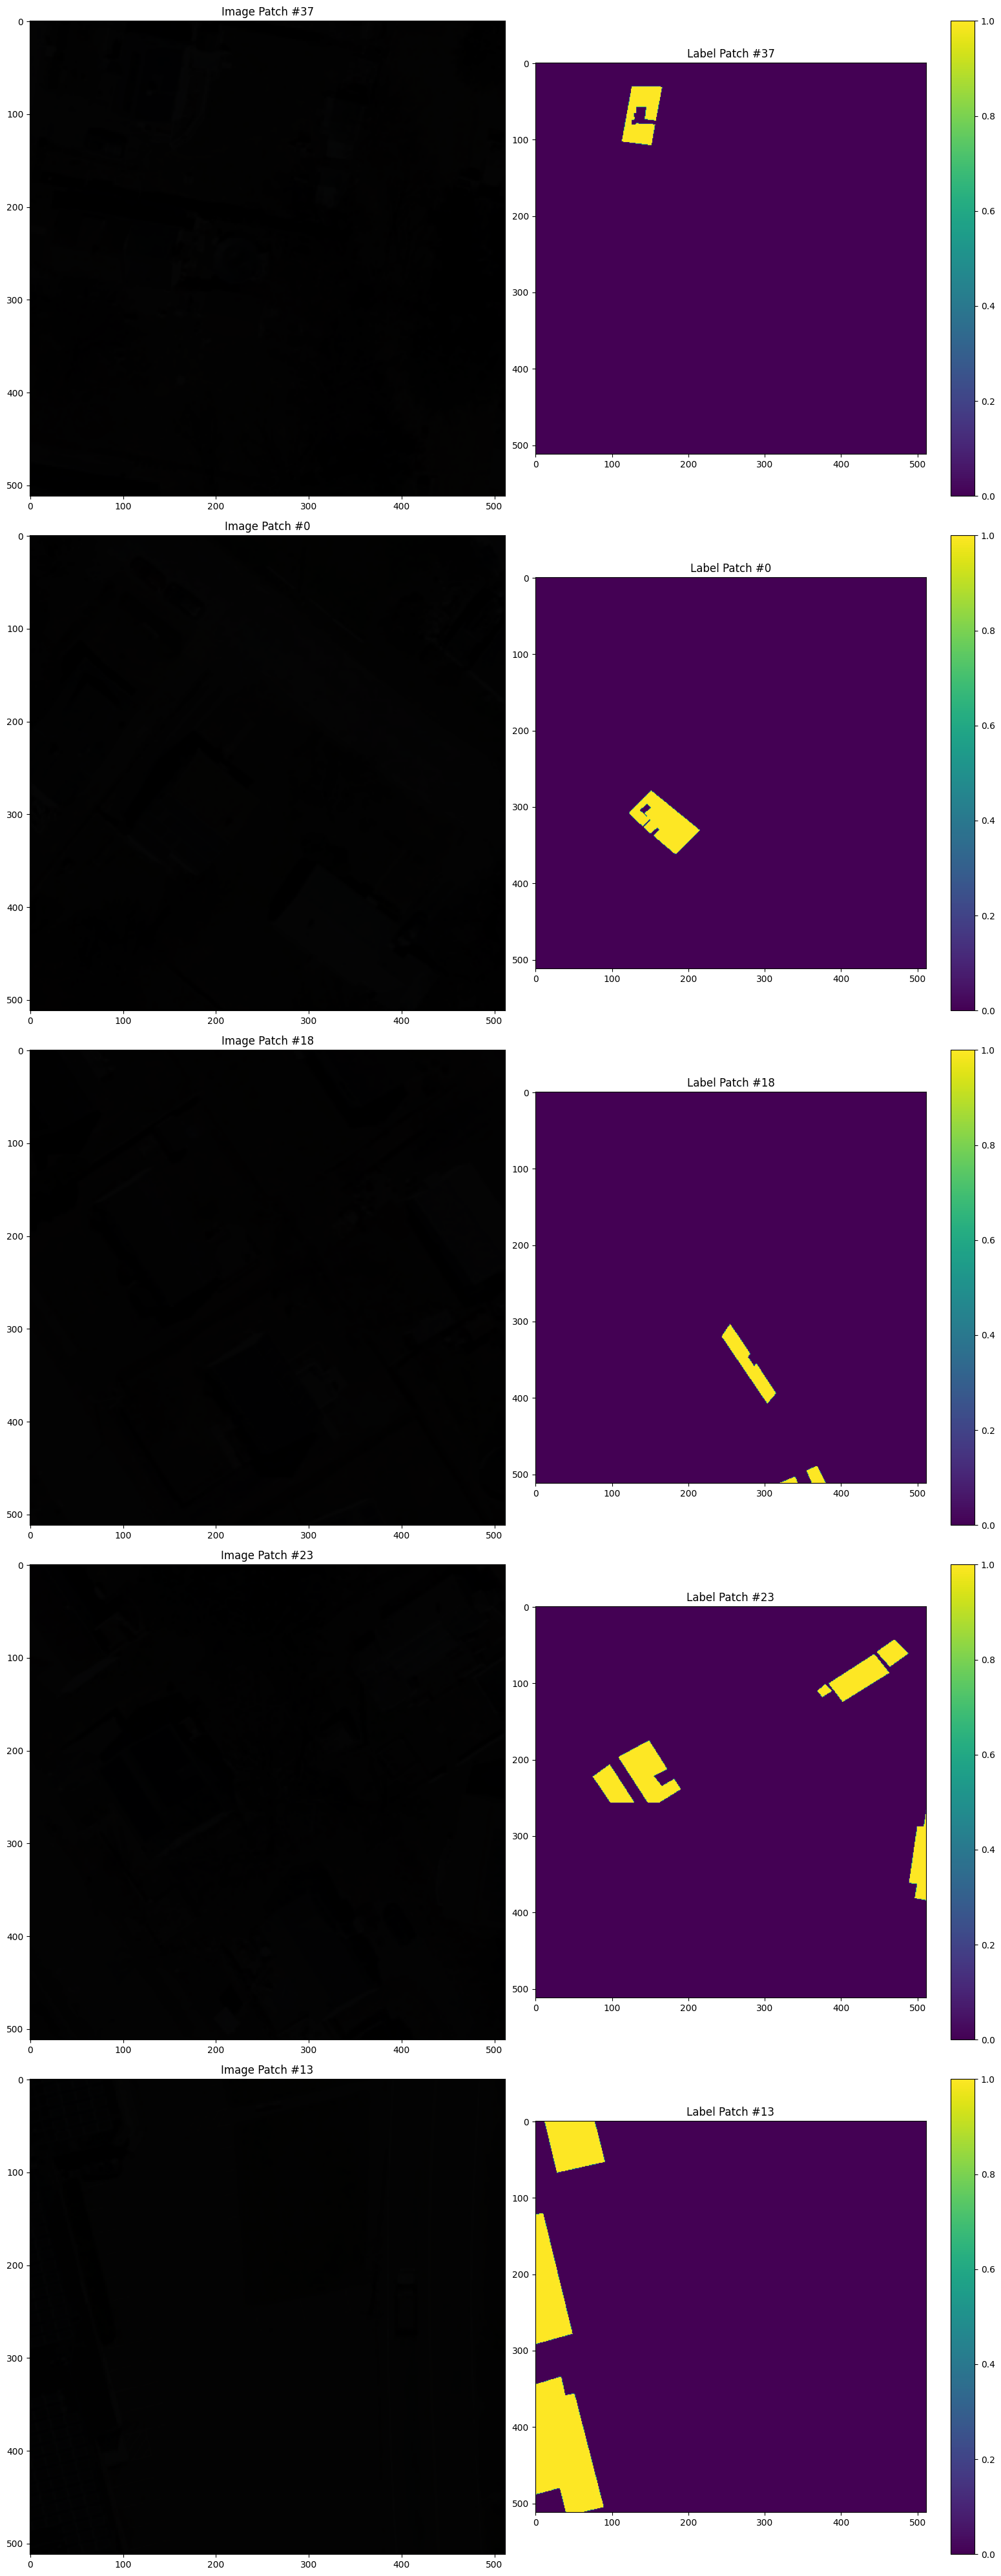

In [67]:
# OPTIONAL
show_random_patches(train_dataset, sample_num=5, rgb_bands=(0, 1, 2))

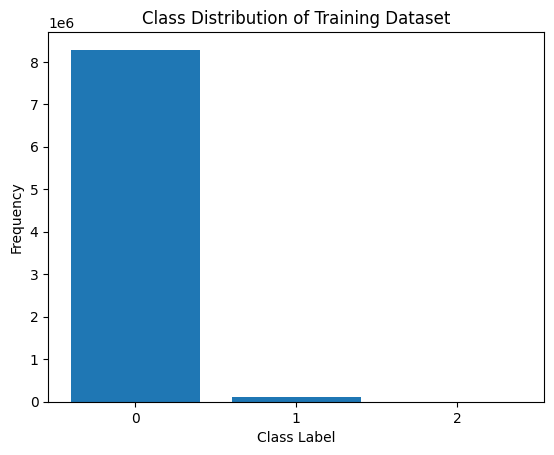

In [23]:
# OPTIONAL
# Check the distribution of categories in a dataset
labels_count = get_labels_distribution(train_dataset, num_classes=3, ignore_class=None)
plot_labels_distribution(labels_count, num_classes=3, ignore_class=None)

In [78]:
# STEP 1-2: Data Batching and Device Assignment
# This code cell batchifies the training dataset using the 'DataLoader' class from PyTorch. The 'DataLoader' 
# efficiently loads the 'train_dataset' in batches, facilitating memory management during training.

train_loader = DataLoader(train_dataset,
                          batch_size=config["train_BatchSize"], 
                          shuffle=True)

In [79]:
# STEP 1-3
# Read the input dataset for validation, pre-process it and generate a 'torch.utils.Dataset' object 
# that can be accepted to get loaded into the model.

val_dataset = CropData(src_dir=config["src_dir"],
                       usage="validation",
                       dataset_name=config["train_dataset_name"],
                       csv_path=config["val_csv_path"],
                       apply_normalization=config["apply_normalization"],
                       normal_strategy=config["normal_strategy"],
                       stat_procedure=config["stat_procedure"],
                       global_stats=config["global_stats"],)

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 88.03it/s]

------ validation dataset with 7 patches created ------


In [13]:
# OPTIONAL
# Check the distribution of categories in a dataset
#labels_count = get_labels_distribution(val_dataset, num_classes=3, ignore_class=None)
#plot_labels_distribution(labels_count, num_classes=3, ignore_class=None)

In [80]:
# STEP 1-4
# Batchify the validation dataset and put it on the defined 'Device'.

val_loader = DataLoader(val_dataset, 
                        batch_size=config["val_test_BatchSize"], 
                        shuffle=False)

In [81]:
# STEP 2: Model Initialization
# The model is based on the U-Net architecture, a popular choice for image segmentation tasks. 

model = Unet(n_classes=config["n_classes"], 
             in_channels=config["input_channels"], 
             use_skipAtt=config["use_skipAtt"],
             filter_config=config["filter_config"],
             dropout_rate=config["train_dropout_rate"])

In [82]:
# STEP 3: Model Compilation and Training Setup
# This code cell compiles the deep learning model, making it ready for training and evaluation. The 'ModelCompiler' 
# class is employed for this purpose, which offers a set of essential functionalities, such as model training 
# ('fit'), model saving, accuracy evaluation ('accuracy_evaluation'), inference ('inference'), and checkpointing 
# with resume capabilities. Additionally, it generates tensorboard reports and graphs for monitoring the training 
# process.

# Note: For training from scratch pass the "params_init" and "freeze_params" as None which results in loading a vanilla
# model with random initialization based on the "model_init_type" parameter. For training with warmup, only change the
# "params_init" to the path to model's saved parameter (not a checkpoint). For fine-tuning, change the "params_init" to 
# the path to model's saved parameter (by default its in the chckpt folder in working directory) and pass a list of integers
# representing the index of layers to be frozen.

compiled_model = ModelCompiler(model,
                               working_dir=config["working_dir"],
                               out_dir=config["out_dir"],
                               num_classes=config["n_classes"],
                               inch=config["input_channels"],
                               class_mapping=config["class_mapping"],
                               gpu_devices=config["gpuDevices"],
                               model_init_type=config["init_type"], 
                               params_init=config["params_init"],
                               freeze_params=config["freeze_params"])

----------GPU available----------
initialize network with kaiming.
total number of trainable parameters: 104.8M
---------- Vanilla Model compiled successfully ----------


In [83]:
# STEP 4: Model Training and Validation
# This code cell trains and validates the compiled deep learning model for the specified number of epochs. 
# The model is trained using the "fit" method provided by the 'compiled_model' object. The training data 
# is obtained from 'train_loader', which contains batched samples and labels. Additionally, the 'val_loader' 
# is used for model validation during training. For each epoch the model reports the average loss value for both 
# training and validation phases, providing insights into its generalization capabilities.

# During the training the "fit" method will create a folder called 'chkpt' inside your working directory
# and save the checkpoints in user-defined intervals in that folder.
# Note: In case the training process is interrupted, you can change the "resume" argument and pass in the
# epoch to resume based on the created checkpoints.

criterion_name = config['criterion']['name']
weight = config['criterion']['weight']
ignore_index = config['criterion']['ignore_index']
gamma = config['criterion']['gamma']

if criterion_name == 'TverskyFocalLoss':
    criterion = TverskyFocalLoss(weight=weight, ignore_index=ignore_index, gamma=gamma)
else:
    criterion = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
    

compiled_model.fit(train_loader,
                   val_loader, 
                   epochs=config["epochs"], 
                   optimizer_name=config["optimizer"], 
                   lr_init=config["LR"],
                   lr_policy=config["LR_policy"], 
                   criterion=criterion, 
                   momentum=config["momentum"],
                   checkpoint_interval=config["checkpoint_interval"],
                   resume=config["resume"],
                   resume_epoch=config["resume_epoch"],
                   **config["lr_prams"])

-------------------------- Start training --------------------------
Epoch [1/20]
train loss:0.7115598491259983
validation loss: 0.6023
LR: 0.01088407840200658
time: 9
Epoch [2/20]
train loss:0.6072483829089573
validation loss: 0.5519
LR: 0.01088407840200658
time: 9
Epoch [3/20]
train loss:0.5173102702413287
validation loss: 0.4863
LR: 0.01076793648428988
time: 9
Epoch [4/20]
train loss:0.4793427756854466
validation loss: 0.4455
LR: 0.010651570995243713
time: 9
Epoch [5/20]
train loss:0.4523831307888031
validation loss: 0.3930
LR: 0.010534978592374402
time: 9
Epoch [6/20]
train loss:0.4251855654375894
validation loss: 0.3537
LR: 0.010418155838529623
time: 9
Epoch [7/20]
train loss:0.3951253209795271
validation loss: 0.2691
LR: 0.0103010991979183
time: 9
Epoch [8/20]
train loss:0.33861349735941204
validation loss: 0.2331
LR: 0.010183805031907068
time: 9
Epoch [9/20]
train loss:0.28299955810819355
validation loss: 0.3445
LR: 0.010066269594577452
time: 9
Epoch [10/20]
train loss:0.2893766

In [46]:
# STEP 5
# Same model parameters
compiled_model.save(save_object="params")

--------------------- Model parameters is saved to disk ---------------------


---------------- Start evaluation ----------------


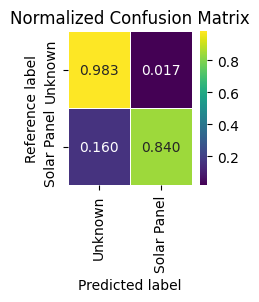

---------------- Evaluation finished in 0s ----------------


In [85]:
# STEP 6
# Generate the accuracy metrics.
metrics = compiled_model.accuracy_evaluation(val_loader, filename=config["val_metric_fname"])


### Steps for prediction

In [93]:
test_dataset = CropData(src_dir=config["src_dir"],
                       usage="inference",
                       dataset_name=config["train_dataset_name"],
                       csv_path=config["val_csv_path"],
                       apply_normalization=config["apply_normalization"],
                       normal_strategy=config["normal_strategy"],
                       stat_procedure=config["stat_procedure"],
                       global_stats=config["global_stats"],)

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 95.17it/s]

------ inference dataset with 7 patches created ------


In [94]:
def meta_handling_collate_fn(batch):
    images = []
    labels = []
    img_ids = []
    img_metas = []

    # Unpack elements from each sample in the batch
    for sample in batch:
        images.append(sample[0])
        labels.append(sample[1])
        img_ids.append(sample[2])
        img_metas.append(sample[3])  # append the dict to the list

    # Stack images and labels into a single tensor
    images = torch.stack(images, dim=0)
    labels = torch.stack(labels, dim=0)
    
    return images, labels, img_ids, img_metas


test_loader = DataLoader(test_dataset, 
                        batch_size=config["val_test_BatchSize"], 
                        shuffle=False,
                        collate_fn=meta_handling_collate_fn
                        )

In [18]:
model = Unet(n_classes=config["n_classes"], 
             in_channels=config["input_channels"], 
             use_skipAtt=config["use_skipAtt"],
             filter_config=config["filter_config"],
             dropout_rate=config["train_dropout_rate"])

In [84]:
compiled_model = ModelCompiler(model,
                               working_dir=config["working_dir"],
                               out_dir=config["out_dir"],
                               num_classes=config["n_classes"],
                               inch=config["input_channels"],
                               class_mapping=config["class_mapping"],
                               gpu_devices=config["gpuDevices"],
                               model_init_type=config["init_type"], 
                               params_init='/home/workdir/solar_test_output/Unet_ep20/chkpt/best_model_checkpoint.pth.tar',
                               freeze_params=config["freeze_params"])

----------GPU available----------
total number of trainable parameters: 104.8M
---------- Pre-trained model compiled successfully ----------


In [96]:
compiled_model.inference(test_loader, out_dir=config["out_dir"])

---------------- Start prediction ----------------
Pred tile: solar_11_4 is written to solar_test_output
Pred tile: solar_17_12 is written to solar_test_output
Pred tile: solar_18_12 is written to solar_test_output
Pred tile: solar_6_13 is written to solar_test_output
Pred tile: solar_6_6 is written to solar_test_output
Pred tile: solar_8_5 is written to solar_test_output
Pred tile: solar_9_5 is written to solar_test_output
---------------- Prediction finished in 0s ----------------
